# 1 | Librerias 📚

In [34]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Pandas
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Seaborn
import seaborn as sns

# Numpy
import numpy as np

# Plotly
import plotly.graph_objects as go
import plotly.express as px

# Sklearn
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, SpectralClustering, HDBSCAN, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Colorama
from colorama import Fore

# Yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Scipy
from scipy.stats import linregress

# Collection
from collections import Counter


# 2 | Cargar el Conjunto de datos 📂

In [35]:
data = pd.read_csv('./segmentation_final.csv')

## 2.1 | Modificar las columnas

In [36]:
# Cambio los nombre de algunas columnas
data.rename({
  'FECHA' : 'InvoiceDate',
  'CLIENTE' : 'CustomerID',
  'DESCRIPCION' : 'Description',
  'UNIDADES' : 'Quantity',
  'ARTICULO' : 'StockCode',
  'CODIGO_COMPRA' : 'InvoiceNo',
  'precio_unitario_final' : 'UnitPrice',
  'Poblacion' : 'Population'
}, inplace = True, axis = 1)

# Elimino variables irrelevantes
data.drop(['FRECUENCIA_ANUAL', 'VENTA_ANUAL', 'codigo_familia', 'codigo_fabricante', 'codigo_grupo', 'antiguedad', 'Population', 'Latitude', 'Longitude'], axis = 1, inplace = True)

# Transformo el tipo de dato de la columna `InvoiceDate` a datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).astype(str)

# Transformo el tipo de dato de la columna `Quantity` a int
data['Quantity'] = data['Quantity'].astype(int)

# 3 | Descripcion del Conjunto de Datos 📖

|Indice|    Variable   |                              Descripcion                          |
|------|---------------|-------------------------------------------------------------------|
|0     |__InvoiceDate__|          _Fecha de la transaccion._                               |
|1     |__CustomerID__ |_Identificador unico para cada cliente._                           |
|2     |__Description__|_Descripcion de cada producto._                                    |
|3     |__Quantity__   |_El numero de unidades de un producto en cada transaccion._        |
|4     |__StockCode__  |_Codigo unico asignado a cada producto._                           |
|5     |__InvoiceNo__  |_Representacion en codigo de una transaccion_                      |
|6     |__UnitPrice__  |_El precio unitario de cada producto_                              |

# 4 | Analisis Inicial de los datos 📊

## 4.1 | Vista del Conjunto de Datos

In [37]:
# Mostrar los primeros registros
data.head()

,InvoiceDate,CustomerID,Description,Quantity,StockCode,InvoiceNo,UnitPrice
0,2024-02-29,1019,GRIFO LLENAVASOS PARA FUENTES DE AGUA REF. 100...,1,002810071,SM1-3128,26.460
1,2024-07-31,1019,TUBO DE ENLACE KOMBIFIX CON TUERCAS REF. 152.4...,1,0044152426461,SM1-11147,23.530
2,2021-01-29,1019,FLOTADOR UNIFILL REF. 240.705.00.1 PARA CISTER...,1,0044240705001,SM1-1785,24.375
3,2024-04-30,1019,Plato de ducha de carga mineral textura pizarr...,1,0060PDSGPZ10070BL,SM1-6071,177.750
4,2023-05-31,1019,VERTEDERO MODELO GARDA A371055000 ROCA,1,00R00601,SM1-8041,141.000


## 4.2 | Resumen Estadistico

In [38]:
# Resumen estadistico para variables numericas
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,697059.0,67790.266929,29074.537211,1019.0,78832.000,79653.00,81496.000,98406.0
Quantity,697059.0,6.998948,28.018910,0.0,1.000,2.00,5.000,5100.0
UnitPrice,692221.0,17.958082,66.808701,0.0,1.375,3.64,10.668,6935.5


In [39]:
# Resumen estadistico para variables categoricas
data.describe(include = 'object').T

,count,unique,top,freq
InvoiceDate,697059,1125,2021-05-25,1075
Description,697059,19804,CODO DE PVC PARA ENCOLAR DE 40 87º HEMBRA HEMB...,5652
StockCode,697059,18911,0804904087,5658
InvoiceNo,697059,61396,SM1-7791,163


# 5 | Limpieza de datos y Transformacion 🧹🪣

## 5.1 | Manejar Valores Faltantes

In [40]:
# Calcular el porcentaje de valores faltantes por cada columna
missing_data = data.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / data.shape[0]) * 100

# Preparar los valores
missing_percentage.sort_values(ascending = False, inplace = True)

# Crear el grafico de barra
fig = go.Figure(go.Bar(
  x = missing_percentage,
  y = missing_percentage.index,
  orientation = 'h',
  marker = dict(color = '#DF2C0C')
))

# Anotar los valores en las barras
fig.update_traces(
  text = missing_percentage.apply(lambda x: f'{x:.2f}%')
)

# Actualizar el diseno
fig.update_layout(
  title = 'Porcentaje de valor nulos',
  xaxis_title = 'Porcentaje (%)',
  yaxis_title = 'Columnas',
  width = 900,
  height = 300
)

# Mostar el grafico
fig.show()

In [41]:
# Mostrar los valores faltantes
data[data['UnitPrice'].isnull()]

,InvoiceDate,CustomerID,Description,Quantity,StockCode,InvoiceNo,UnitPrice
50,2021-03-31,1019,MECANISMO UNIVERSAL DE ALIMENTACION INFERIOR P...,2,00R9822502300,SM1-5948,NaN
853,2021-01-12,1019,GRIFO DE LAVADORA ( ELECTRODOMESTICOS ) MODELO...,1,0610L851234,SM1-457,NaN
2540,2021-03-12,1043,GRIFO DE LAVADORA ( ELECTRODOMESTICOS ) MODELO...,4,0610L851234,SM1-4742,NaN
3385,2022-12-28,1128,Electrobomba sumergible para achique VORTEX 20...,2,0318VORTEX200M,SM1-20065,NaN
3513,2021-07-17,1128,GRIFO DE LAVADORA ( ELECTRODOMESTICOS ) MODELO...,1,0610L851234,SM1-13152,NaN
...,...,...,...,...,...,...,...
695666,2024-01-12,98317,ESPEJO ROTA DE 400 x 800 mm HORIZONTAL Y VERTI...,1,070820729,8-376,NaN
695692,2022-10-19,98317,MAMPARA CRISTAL FIJO PARA DUCHA MODELO SCREEN ...,1,07AW0164,8-10237,NaN
695693,2023-04-18,98317,MAMPARA CRISTAL FIJO PARA DUCHA MODELO SCREEN ...,1,07AW0164,8-3616,NaN
695701,2023-05-05,98317,Mampara especial gme presupuesto pedro castill...,1,07AWMPE2023,8-4225,NaN


In [42]:
# Crear un diccionario con los StockCodes y los valores que deseas asignar
values_map = {
  '0610L851234': 9.84,
  '0609MA1238ST': 4.57,
  '05CGWR104KBGN': 515,
  '02521141676': 69,
  '0719VCD1308': 295,
  '013823619': 13,
  '01598DR001': 219,
  '010944ST26290301': 187,
  '090602224': 2.18,
  '0159BDB008': 60.5,
  '32RB270E20090': 21.9,
  '01R1TANCR01': 121
}

# Actualizar la columna 'UnitPrice' basada en el 'StockCode'
data.loc[data['StockCode'].isin(values_map.keys()), 'UnitPrice'] = data['StockCode'].map(values_map)

In [43]:
# Elimino los valores faltantes
data = data.dropna(subset = ['UnitPrice'])

# Mostrar el numero de valores nulos
data.isnull().sum().sum()

0

## 5.2 | Manejar Duplicados

In [44]:
# Econtrar filas duplicadas
duplicated_rows = data[data.duplicated(keep = False)]

# Ordenar la data de acuerdo a ciertas columnas para ver los duplicados uno a lado del otro
duplicated_rows_sorted = duplicated_rows.sort_values(by = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Mostrar los registros
duplicated_rows_sorted

,InvoiceDate,CustomerID,Description,Quantity,StockCode,InvoiceNo,UnitPrice
299981,2022-02-15,79561,REDUCCION MACHO HEMBRA FIGURA 243 DE COBRE DE ...,10,0201CU2432218,2-1010,0.79600
299982,2022-02-15,79561,REDUCCION MACHO HEMBRA FIGURA 243 DE COBRE DE ...,10,0201CU2432218,2-1010,0.79600
121301,2024-02-08,14177,MONOMANDO DE FREGADERO MURAL ENKEL DE 11cm CON...,1,013823608CC,2-1023,35.19000
121302,2024-02-08,14177,MONOMANDO DE FREGADERO MURAL ENKEL DE 11cm CON...,1,013823608CC,2-1023,35.19000
301760,2024-02-08,79561,BOTE DE LIMPIADOR TANGIT DE 1/2 LITRO PARA PVC...,1,0807L500,2-1045,11.57685
...,...,...,...,...,...,...,...
34552,2021-05-31,2247,K 61 RACOR ENLACE MIXTO MACHO POLIE 20 1/2 JIMTEN,3,02116112,SM1-9853,1.42200
430109,2023-07-05,80471,MANGUITO HEMBRA HEMBRA FIGURA 270 DE COBRE DE 22,6,0201CU2722,SM1-9865,0.58100
430110,2023-07-05,80471,MANGUITO HEMBRA HEMBRA FIGURA 270 DE COBRE DE 22,6,0201CU2722,SM1-9865,0.58100
106027,2024-01-22,10005,K 64 CODO DE METAL MIXTO MACHO DE 32 1 PARA PO...,1,0209921,SM1-989,8.85000


In [45]:
# Mostrar el numero de filas duplicadas
print(f'El conjunto de datos contiene {data.duplicated().sum()} filas duplicadas')

# Eliminar filas duplicadas
data.drop_duplicates(inplace = True)

El conjunto de datos contiene 1698 filas duplicadas


# 6 | Ingenieria de Datos 🔩

## 6.1 | RFM Caracteristicas

### 6.1.1 | Recency

In [46]:
# Convertir InvoiceDate a tipo de dato datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Convertir InvoiceDate a tipo de dato datetime y extraer solo la fecha
data['InvoiceDay'] = data['InvoiceDate'].dt.date

# Encontrar el día de compra más reciente por cada cliente
customer_data = data.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Encontrar el día de compra más reciente en el conjunto de datos
most_recent_date = data['InvoiceDay'].max()

# Convertir InvoiceDay a tipo de dato datetime antes de restar
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculamos el número de días desde la última compra por cada cliente
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Removemos la columna InvoiceDay
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [47]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,1019,24
1,1025,96
2,1032,573
3,1035,395
4,1043,59


### 6.1.2 | Frecuency

In [48]:
# Calcular el número total de transacciones realizadas por cada cliente
total_transactions = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns = {'InvoiceNo' : 'Total_Transactions'}, inplace = True)

# Calcular el número total de productos comprados por cada cliente
total_products_purchased = data.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns = {'Quantity' : 'Total_Products_Purchased'}, inplace = True)

# Fusionar las nuevas características en el dataframe `customer_data`
customer_data = pd.merge(customer_data, total_transactions, on = 'CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on = 'CustomerID')

In [49]:
# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,1019,24,121,8147
1,1025,96,9,21
2,1032,573,3,10
3,1035,395,4,63
4,1043,59,12,434


### 6.1.3 | Monetary

In [50]:
# Calcular el gasto total de cada cliente
data['Total_Spend'] = data['UnitPrice'] * data['Quantity']
total_spend = data.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calcular el valor promedio de transacción para cada cliente
average_transaction_value = total_spend.merge(total_transactions, on = 'CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Fusionar las nuevas características en el dataframe `customer_data`
customer_data = pd.merge(customer_data, total_spend, on = 'CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on = 'CustomerID')

In [51]:
# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,1019,24,121,8147,45342.440021,374.730909
1,1025,96,9,21,262.194323,29.132703
2,1032,573,3,10,110.658887,36.886296
3,1035,395,4,63,156.633500,39.158375
4,1043,59,12,434,2081.804448,173.483704


## 6.2 | Diversidad de Productos

In [52]:
# Calcular el numero de productos unicos comprados por cada cliente
unique_products_purchased = data.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns = {'StockCode' : 'Unique_Products_Purchased'}, inplace = True)

# Combinamos la nueva caracteristica dentro del dataframe `customer_data`
customer_data = pd.merge(customer_data, unique_products_purchased, on = 'CustomerID')

In [53]:
# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,1019,24,121,8147,45342.440021,374.730909,850
1,1025,96,9,21,262.194323,29.132703,15
2,1032,573,3,10,110.658887,36.886296,9
3,1035,395,4,63,156.633500,39.158375,6
4,1043,59,12,434,2081.804448,173.483704,64


## 6.3 | Caracteristicas de Comportamiento

In [54]:
# Extraer dia de la semana de la columna InvoiceDate
data['Day_Of_Week'] = data['InvoiceDate'].dt.dayofweek

# Calcular el número promedio de días entre compras consecutivas
days_between_purchases = data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Encontrar el dia de la semana favorito de compra
favorite_shopping_day = data.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name = 'Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Combinamos las nuevas caracteristicas dentro del dataframe `customer_data`
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')

In [55]:
# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week
0,1019,24,121,8147,45342.440021,374.730909,850,0.051569,4
1,1025,96,9,21,262.194323,29.132703,15,-6.750000,4
2,1032,573,3,10,110.658887,36.886296,9,-64.375000,4
3,1035,395,4,63,156.633500,39.158375,6,-16.200000,0
4,1043,59,12,434,2081.804448,173.483704,64,-1.579710,4


## 6.4 | Estacionalidad y Tendencias

In [56]:
# Extraer mes y año de InvoiceDate
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month

# Calcular el gasto mensual para cada cliente
monthly_spending = data.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calcular Patrones de Compra Estacionales: Usamos la frecuencia mensual como un proxy para los patrones de compra estacionales
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Reemplazar valores NaN en Monthly_Spending_Std con 0, implicando que no hay variabilidad para clientes con un solo mes de transacción
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calcular Tendencias en el Gasto
# Usamos la pendiente de la línea de tendencia lineal ajustada al gasto del cliente a lo largo del tiempo como un indicador de las tendencias de gasto
def calculate_trend(spend_data):
  # Si hay más de un punto de datos, calculamos la tendencia utilizando regresión lineal.
  if len(spend_data) > 1:
    x = np.arange(len(spend_data))
    slope, _, _, _, _ = linregress(x, spend_data)
    return slope
  # Si solo hay un punto de datos, no se puede calcular la tendencia, por lo tanto devolvemos 0.
  else:
    return 0


# Aplicar la función calculate_trend para encontrar la tendencia de gasto para cada cliente
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Fusionar las nuevas características en el dataframe customer_data
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

In [57]:
# Mostrar las primeras filas del dataframe customer_data
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,1019,24,121,8147,45342.440021,374.730909,850,0.051569,4,1133.561001,985.831859,44.736502
1,1025,96,9,21,262.194323,29.132703,15,-6.750000,4,37.456332,52.802667,4.891042
2,1032,573,3,10,110.658887,36.886296,9,-64.375000,4,36.886296,55.921840,47.187500
3,1035,395,4,63,156.633500,39.158375,6,-16.200000,0,39.158375,68.704771,14.434050
4,1043,59,12,434,2081.804448,173.483704,64,-1.579710,4,231.311605,208.619651,-35.731648


In [58]:
# Cambiar el tipo de dato de 'CustomerID' a cadena ya que es un identificador único y no se utiliza en operaciones matemáticas
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convertir los tipos de datos de las columnas a los tipos óptimos
customer_data = customer_data.convert_dtypes()

In [59]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,1019,24,121,8147,45342.440021,374.730909,850,0.051569,4,1133.561001,985.831859,44.736502
1,1025,96,9,21,262.194323,29.132703,15,-6.75,4,37.456332,52.802667,4.891042
2,1032,573,3,10,110.658887,36.886296,9,-64.375,4,36.886296,55.92184,47.1875
3,1035,395,4,63,156.6335,39.158375,6,-16.2,0,39.158375,68.704771,14.43405
4,1043,59,12,434,2081.804448,173.483704,64,-1.57971,4,231.311605,208.619651,-35.731648


## Descripcion del Conjunto de Datos

|Indice|           Variable          |                              Descripcion                          |
|------|-----------------------------|-------------------------------------------------------------------|
|0     |__CustomerID__               |  _Identificador unico para cada cliente._                         |
|0     |__Days_Since_Last_Purchase__               |  _El número de días que han pasado desde la última compra del cliente._|
|0     |__Total_Transactions__               |  _El número total de transacciones realizadas por el cliente._|
|0     |__Total_Products_Purchased__               |  _La cantidad total de productos comprados por el cliente en todas las transacciones._|
|1     |__Total_Spend__ |_La cantidad total de dinero que el cliente ha gastado en todas las transacciones._                           |
|1     |__Average_Transaction_Value__ |_El valor promedio de las transacciones del cliente, calculado como el gasto total dividido por el número de transacciones._|
|2     |__Unique_Products_Purchased__|_El numero de productos diferentes que el cliente ha comprado._|
|2     |__Average_Days_Between_Purchases__|_El número promedio de días entre compras consecutivas realizadas por el cliente._ |
|2     |__Day_Of_Week__|_El día de la semana en que el cliente prefiere comprar, representado numéricamente (0 para lunes, 6 para domingo)._|
|2     |__Monthly_Spending_Mean__|_El gasto mensual promedio del cliente._|
|2     |__Monthly_Spending_Std__|_La desviación estándar del gasto mensual del cliente, que indica la variabilidad en su patrón de gasto._|
|3     |__Sprending_Trend__   |_Una representacion numerica de la tendencia en el gasto del cliente a lo largo del tiempo._|

In [60]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349 entries, 0 to 3348
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      3349 non-null   string 
 1   Days_Since_Last_Purchase        3349 non-null   Int64  
 2   Total_Transactions              3349 non-null   Int64  
 3   Total_Products_Purchased        3349 non-null   Int32  
 4   Total_Spend                     3349 non-null   Float64
 5   Average_Transaction_Value       3349 non-null   Float64
 6   Unique_Products_Purchased       3349 non-null   Int64  
 7   Average_Days_Between_Purchases  3349 non-null   Float64
 8   Day_Of_Week                     3349 non-null   Int32  
 9   Monthly_Spending_Mean           3349 non-null   Float64
 10  Monthly_Spending_Std            3349 non-null   Float64
 11  Spending_Trend                  3349 non-null   Float64
dtypes: Float64(6), Int32(2), Int64(3),

# 7 | Analisis de Correlacion 🗿

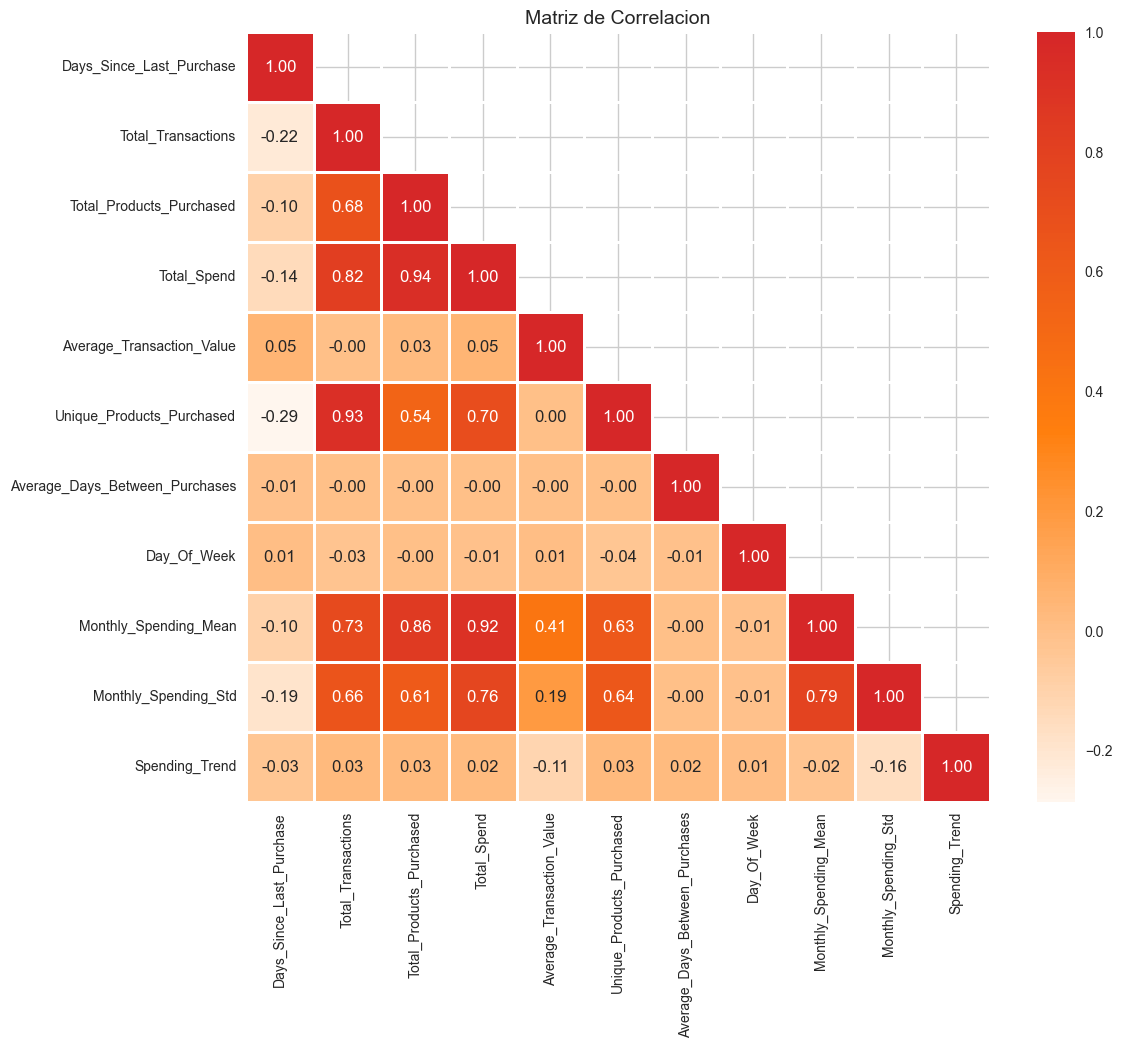

In [61]:
# Quitamos la columna CustomerID para la matriz de correlacion
customer_data_filter = customer_data.drop(columns = ['CustomerID'])

# Calcular la matriz de correlacion
corr = customer_data_filter.corr()

# Definimos un colormap propio
colors = ["#1f77b4", "#ffffff", "#ff7f0e", "#d62728"]
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N = 256)

# Crear una mascara para mostrar solor el triangulo inferior de la matriz
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k = 1)] = True

# Graficar el heatmap
plt.figure(figsize = (12, 10))
sns.set_style('whitegrid')
sns.heatmap(corr, mask = mask, cmap = my_cmap, annot = True, center = 0, fmt = '.2f', linewidths = 2)
plt.title('Matriz de Correlacion', fontsize = 14)

# Mostrar el grafico
plt.show()

# 8 | Estandarizar Caracteristicas 🚀

In [62]:
# Crear instancia de StandardScaled
scaler = StandardScaler()

# Lista de columnas que no necesitan ser escaladas
columns_to_exclude = ['CustomerID', 'Day_Of_Week']

# Lista de columnas que necesitan ser escaladas
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# Copia del dataframe limpio
customer_data_scaled = customer_data.copy()

# Aplicamos el scaler a las columnas que tienen que ser escaladas
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Establesco como indice el CustomerID
customer_data_scaled.set_index('CustomerID', inplace = True)

# Mostrar el dataframe escalado
customer_data_scaled.head()

,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
CustomerID,,,,,,,,,,,
1019,-0.917903,0.338249,0.506766,0.924276,0.686812,3.459553,-0.004033,4,0.804424,1.355713,0.316041
1025,-0.736148,-0.225551,-0.108148,-0.167750,-0.308252,-0.308849,-0.078244,4,-0.293189,-0.305260,0.131778
1032,0.467977,-0.255755,-0.108980,-0.171421,-0.285928,-0.335927,-0.706988,4,-0.293759,-0.299707,0.327376
1035,0.018639,-0.250721,-0.104969,-0.170308,-0.279386,-0.349466,-0.181353,0,-0.291484,-0.276951,0.175909
1043,-0.829550,-0.210450,-0.076895,-0.123672,0.107371,-0.087709,-0.021831,4,-0.099067,-0.027875,-0.056080


# 9 | Reduccion de Dimensionalidad 🔎

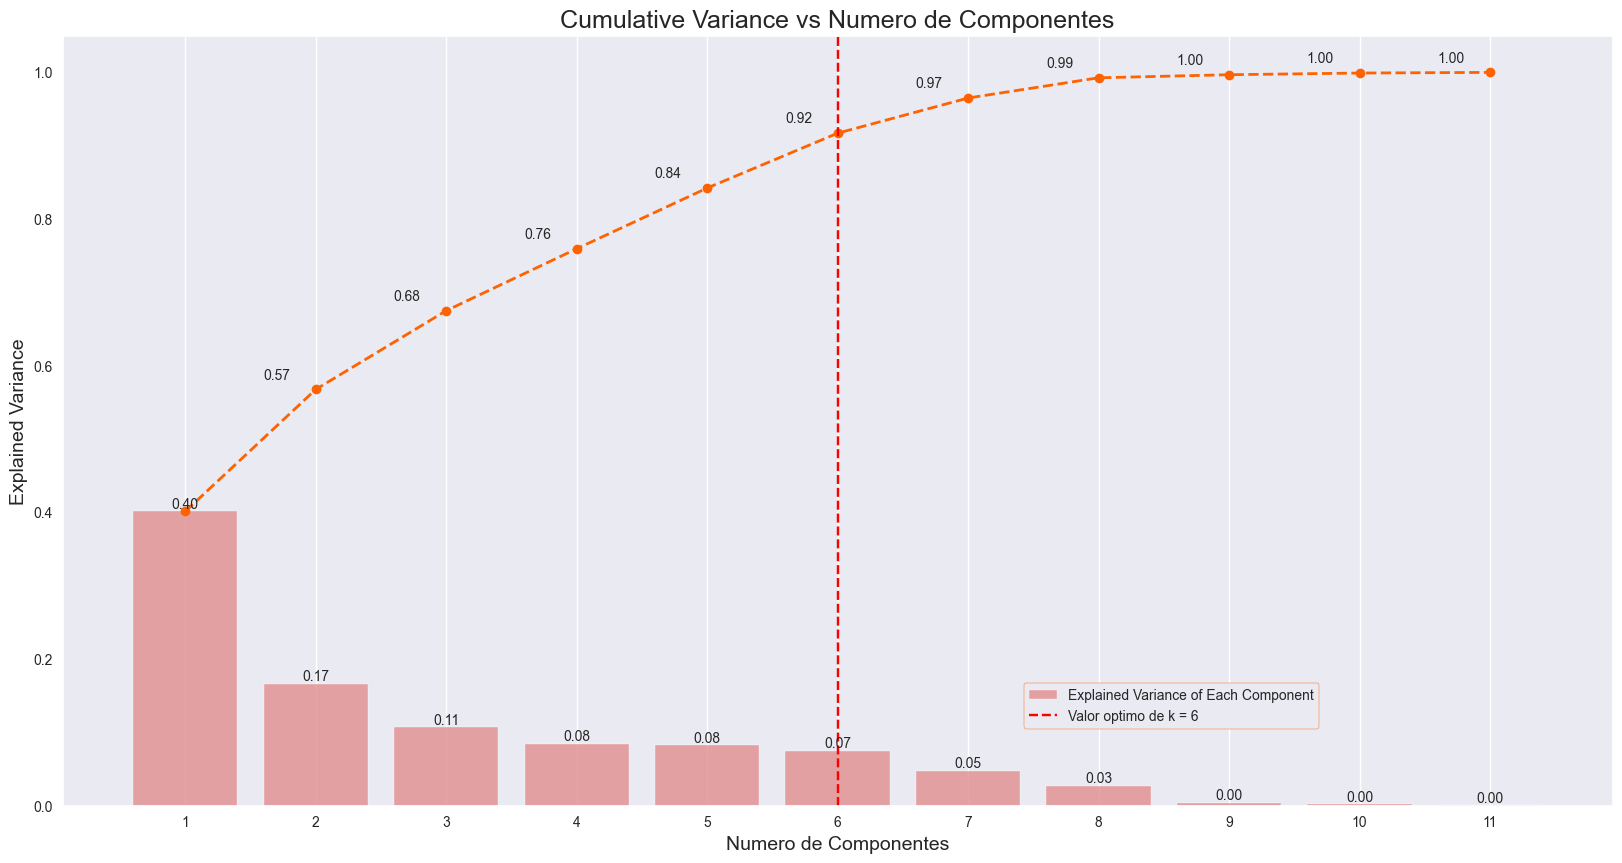

In [63]:
# Aplicar pca
pca = PCA().fit(customer_data_scaled)

# Calcular la Cumulative Sum de la Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Establecer el valor de k
optimal_k = 6

# Graficar
sns.set_style('darkgrid')

# Graficar Cumulative Explainded Variance contrar el numero de componentes
plt.figure(figsize = (20, 10))

# Grafico de barras para la Varance Explained por cada componente
barplot = sns.barplot(x = list(range(1, len(cumulative_explained_variance) + 1)), y = explained_variance_ratio, color = '#F08080', alpha = 0.8)

# Grafico lineal para la Cumulative Explained Variance
lineplot = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker = 'o', linestyle = '--', color = '#FF6200', linewidth = 2)

# Graficar la linea del valor de k optimo
optimal_k_line = plt.axvline(optimal_k - 1, color = 'red', linestyle = '--', label = f'Valor optimo de k = {optimal_k}')

# Establecer etiquetas y titulo
plt.xlabel('Numero de Componentes', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14)
plt.title('Cumulative Variance vs Numero de Componentes', fontsize = 18)

# Personalizar marcas y legenda
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles = [barplot.patches[0], lineplot, optimal_k_line], labels = ['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Valor optimo de k = {optimal_k}'], loc = (0.62, 0.1), frameon = True, framealpha = 1.0, edgecolor = '#FF6200')

# Mostrar los valores de la varianza para cada grafico
x_offset = -0.3
y_offset = 0.01

for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
  plt.text(i, ev_ratio, f'{ev_ratio:.2f}', ha = 'center', va = 'bottom', fontsize = 10)
  if i > 0:
    plt.text(i + x_offset, cum_ev_ratio + y_offset, f'{cum_ev_ratio:.2f}', ha = 'center', va = 'bottom', fontsize = 10)
    
plt.grid(axis = 'both')
plt.show()

In [64]:
customer_data.set_index('CustomerID')

,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
CustomerID,,,,,,,,,,,
1019,24,121,8147,45342.440021,374.730909,850,0.051569,4,1133.561001,985.831859,44.736502
1025,96,9,21,262.194323,29.132703,15,-6.75,4,37.456332,52.802667,4.891042
1032,573,3,10,110.658887,36.886296,9,-64.375,4,36.886296,55.92184,47.1875
1035,395,4,63,156.6335,39.158375,6,-16.2,0,39.158375,68.704771,14.43405
1043,59,12,434,2081.804448,173.483704,64,-1.57971,4,231.311605,208.619651,-35.731648
...,...,...,...,...,...,...,...,...,...,...,...
98026,61,13,51,453.730397,34.902338,26,-0.964286,4,37.810866,37.700583,-3.860215
98027,74,45,176,2409.074184,53.534982,77,-5.380435,1,96.362967,181.163741,-2.3999
98156,278,3,31,123.917753,41.305918,4,116.333333,2,41.305918,26.57051,-16.505


# 10 | Visualizaciones 📈📉

In [65]:
# # Establecer el estilo visual de las graficas
# sns.set_style('darkgrid')

# # Definir una paleta personalizada para las visualizaciones
# custom_palette = ['#06d6a0', '#118ab2', '#ef476f']

# # Definir una lista de nombres de columnas del DataFrame que queremos visualizar
# list_of_columns = customer_data.drop(columns = 'CustomerID')

# # Crear una cuadricula de subgraficas con 2 columnas
# fig, axs = plt.subplots(len(list_of_columns), 2, figsize = (15, 8))

# # Iterar sobre cada nombre de columna, utilizando 'enumerate' para obtener tanto el nombre como el indice del bucle
# for indice, column_name in enumerate(list_of_columns):
#   # Dibujar un histograma para cada columna
#   sns.histplot(data = customer_data, x = column_name, ax = axs[indice, 0], kde = True, color = '#FB8500', bins = 30)
  
#   # Establecer el titulo para cada histograma para indicar que datos representa
#   axs[indice, 0].set_title(f'Histograma de {column_name}')
  
#   # Dibujar un boxplot para cada columna para mostrar la distribucion de valores
#   sns.boxplot(data = customer_data, x = column_name, ax = axs[indice , 1], palette = [custom_palette[indice % len(custom_palette)]])
  
#   # Establecer el titulo para cada boxplot para indicar que datos representa
#   axs[indice, 1].set_title(f'Boxplot de {column_name}')
  
# # Ajustar el dise;o de las subgraficas para evitar que se superpongan elementos
# plt.tight_layout()

# # Mostrar la grafica
# plt.show()

# 11 | Deteccion de Valores Atipicos 📐

In [66]:
# Inicializar el modelo IsolationForest
isolation_forest = IsolationForest(contamination = 0.5, random_state = 42)

# Ajustar el modelo a nuestro conunto de datos
customer_data['Outlier_Score'] = isolation_forest.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Crear una columna para identificar outliers
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Score']]

# Mostrar resultado
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Score,Is_Outlier
0,1019,24,121,8147,45342.440021,374.730909,850,0.051569,4,1133.561001,985.831859,44.736502,-1,1
1,1025,96,9,21,262.194323,29.132703,15,-6.75,4,37.456332,52.802667,4.891042,1,0
2,1032,573,3,10,110.658887,36.886296,9,-64.375,4,36.886296,55.92184,47.1875,-1,1
3,1035,395,4,63,156.6335,39.158375,6,-16.2,0,39.158375,68.704771,14.43405,1,0
4,1043,59,12,434,2081.804448,173.483704,64,-1.57971,4,231.311605,208.619651,-35.731648,-1,1


## 11.1 | Visualizacion de Outliers

In [67]:
# Calcular el porcentaje de datos Inliers y Outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize = True) * 100

# Crear el grafico de anillo
fig = px.pie(
  values = outlier_percentage.values,
  names = ['Datos Validos', 'Valores Atipicos'],
  title = 'Porcentaje de Datos Validos y Valores Atipicos',
  hole = 0.4,
  color_discrete_sequence = ['#DF2C0C', '#2aa915']
)

# Anotar los valores en el grafico
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')

# Mostrar el grafico
fig.show()

In [68]:
# Removerla columna Outlier Score
customer_data.drop(columns = 'Outlier_Score', inplace = True)

# Mostrar resultado
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Is_Outlier
0,1019,24,121,8147,45342.440021,374.730909,850,0.051569,4,1133.561001,985.831859,44.736502,1
1,1025,96,9,21,262.194323,29.132703,15,-6.75,4,37.456332,52.802667,4.891042,0
2,1032,573,3,10,110.658887,36.886296,9,-64.375,4,36.886296,55.92184,47.1875,1
3,1035,395,4,63,156.6335,39.158375,6,-16.2,0,39.158375,68.704771,14.43405,0
4,1043,59,12,434,2081.804448,173.483704,64,-1.57971,4,231.311605,208.619651,-35.731648,1


# 12 | KMeans 📔

In [69]:
# Crear una varaible donde guardaremos los resultados
result = []

# Inicializar parametros
init_methods = ['random', 'k-means++']

# Iterar a traves de diferentes metodos de inicializacion y numero de clusters para evaluar metricas
for init in init_methods:
  for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, init = init, n_init = 10, max_iter = 500, random_state = 42)
    kmeans_labels = kmeans.fit_predict(customer_data_scaled)
    
    # Calcular metricas de evaluacion
    silhouette = silhouette_score(customer_data_scaled, kmeans_labels)
    db_score = davies_bouldin_score(customer_data_scaled, kmeans_labels)
    ch_score = calinski_harabasz_score(customer_data_scaled, kmeans_labels)
    
    # Almacenar los resultados
    result.append((init, k, kmeans.inertia_, silhouette, db_score, ch_score))

# Convertir resultados a un DataFrame
results_df = pd.DataFrame(result, columns = ['Metodo de Inicializacion', 'Numero de Clusters', 'Inercia', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score'])

# Mostrar los resultados
print(Fore.RED + """
********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering
********************************************************************************************************************
""")

display(results_df.sort_values(by = ['Silhouette Score'], ascending = False))

# Determinar los mejores parametros basados en el Silhouette Score
best_result = results_df.loc[results_df['Silhouette Score'].idxmax()]

# Mejor metodo de Inicializacion
best_init = best_result['Metodo de Inicializacion']

# Mejor numero de clusters
best_k = best_result['Numero de Clusters']

# Imprimimos los resultados
print(f'Mejor Metodo de Inicializacion: {best_init}')
print(f'Mejor Numero de Clusters (basado en Silhouette Score): {best_k}')


********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering
********************************************************************************************************************



,Metodo de Inicializacion,Numero de Clusters,Inercia,Silhouette Score,Davies Bouldin Score,Calinski Harabasz Score
0,random,2,31835.950001,0.734618,0.855552,875.912874
9,k-means++,2,31835.950001,0.734618,0.855552,875.912874
14,k-means++,7,16135.169094,0.310833,0.831977,829.615009
13,k-means++,6,17727.595970,0.305274,0.975085,846.323665
17,k-means++,10,12379.137404,0.305204,0.880211,832.812448
16,k-means++,9,13614.072218,0.294842,0.860202,814.309985
15,k-means++,8,14614.303991,0.293981,0.877081,834.537123
6,random,8,16077.066163,0.292492,1.035802,715.179886
12,k-means++,5,19901.825363,0.289157,1.002337,851.286198
2,random,4,22598.632282,0.287090,1.077942,866.832448


Mejor Metodo de Inicializacion: random
Mejor Numero de Clusters (basado en Silhouette Score): 2



********************************************************************************************************************
                                      Visualizacion del Metodo del codo
********************************************************************************************************************



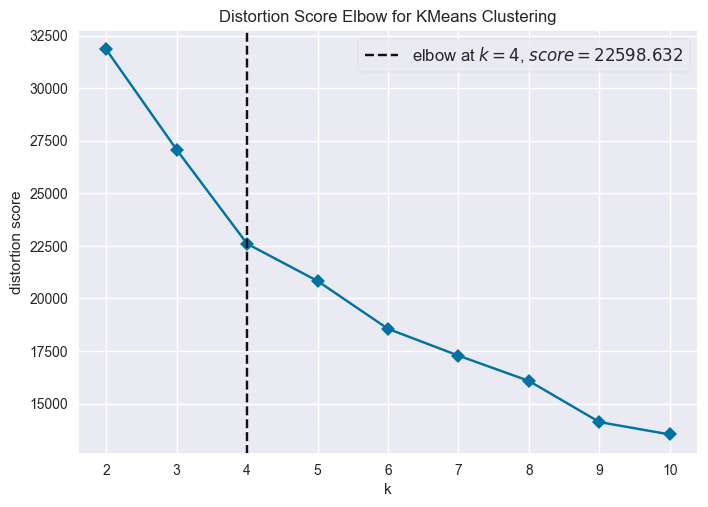

In [70]:
# Visualizar el metodo del Codo
print(Fore.RED + """
********************************************************************************************************************
                                      Visualizacion del Metodo del codo
********************************************************************************************************************
""")

elbow_visualizer = KElbowVisualizer(KMeans(init = best_init, n_init = 10, max_iter = 500, random_state = 42), k = (2, 11), timings = False)
elbow_visualizer.fit(customer_data_scaled)
elbow_visualizer.finalize()

plt.show()

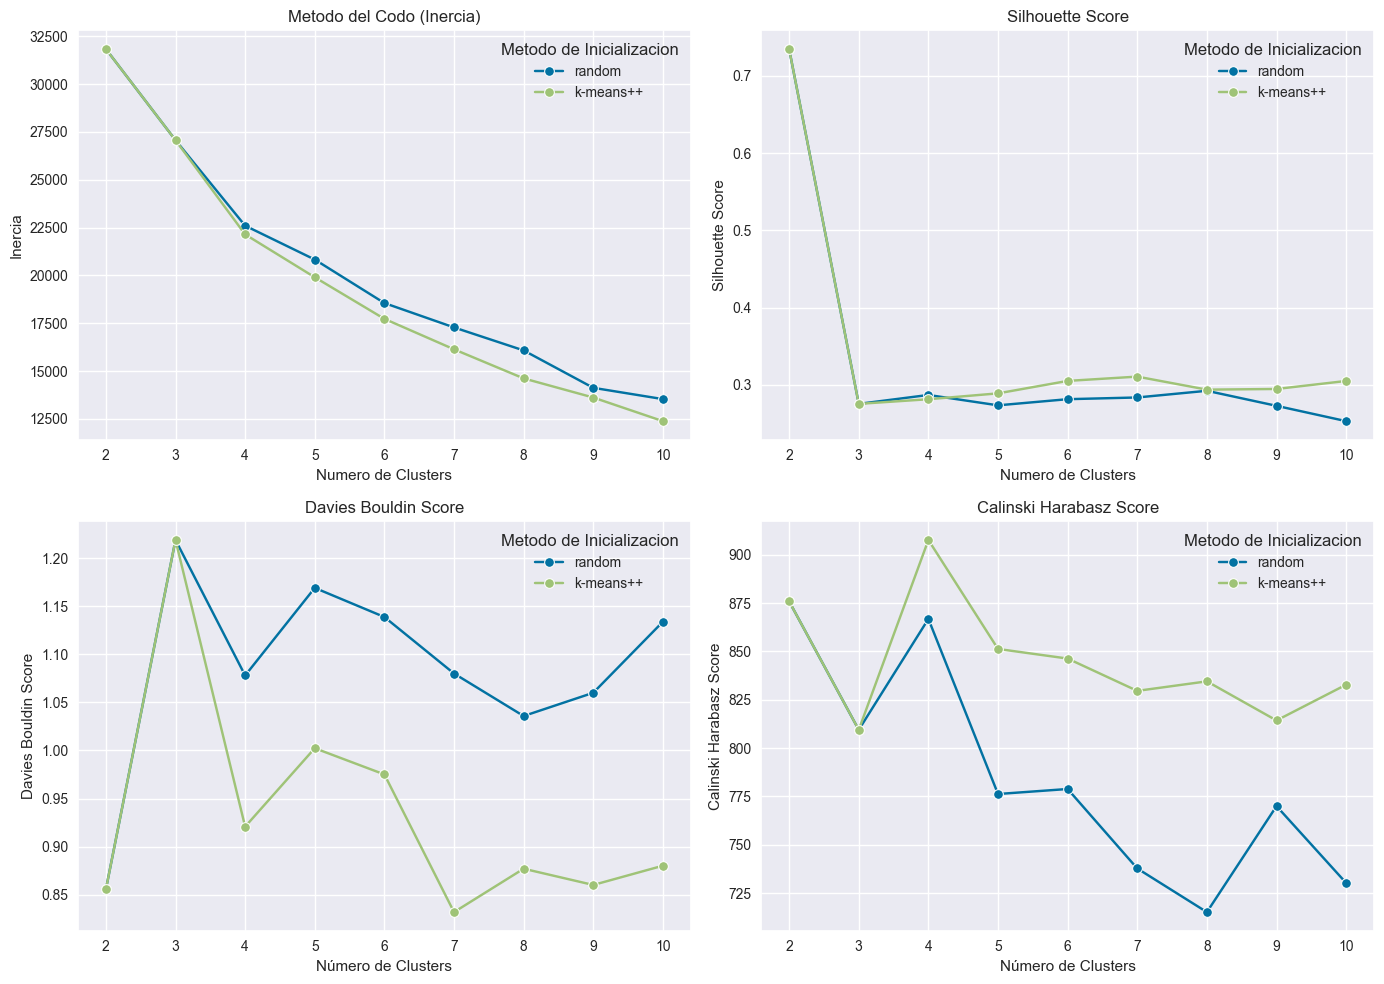

In [71]:
# Definir una funcion para graficas las metricas de evaluacion
fig, axs = plt.subplots(2, 2, figsize = (14, 10))

sns.lineplot(
  x = 'Numero de Clusters',
  y = 'Inercia',
  hue = 'Metodo de Inicializacion',
  data = results_df,
  ax = axs[0, 0],
  marker = 'o'
)
axs[0, 0].set_title('Metodo del Codo (Inercia)')
axs[0, 0].set_xlabel('Numero de Clusters')
axs[0, 0].set_ylabel('Inercia')

sns.lineplot(
  x = 'Numero de Clusters',
  y = 'Silhouette Score',
  hue = 'Metodo de Inicializacion',
  data = results_df,
  ax = axs[0, 1],
  marker = 'o'
)
axs[0, 1].set_title('Silhouette Score')
axs[0, 1].set_xlabel('Numero de Clusters')
axs[0, 1].set_ylabel('Silhouette Score')

sns.lineplot(
  x = 'Numero de Clusters',
  y = 'Davies Bouldin Score',
  hue = 'Metodo de Inicializacion',
  data = results_df,
  ax = axs[1, 0],
  marker = 'o'
)
axs[1, 0].set_title('Davies Bouldin Score')
axs[1, 0].set_xlabel('Número de Clusters')
axs[1, 0].set_ylabel('Davies Bouldin Score')

sns.lineplot(
  x = 'Numero de Clusters',
  y = 'Calinski Harabasz Score',
  hue = 'Metodo de Inicializacion',
  data = results_df,
  ax = axs[1, 1],
  marker = 'o'
)
axs[1, 1].set_title('Calinski Harabasz Score')
axs[1, 1].set_xlabel('Número de Clusters')
axs[1, 1].set_ylabel('Calinski Harabasz Score')

plt.tight_layout()
plt.show()

Counter({1: 3276, 0: 73})


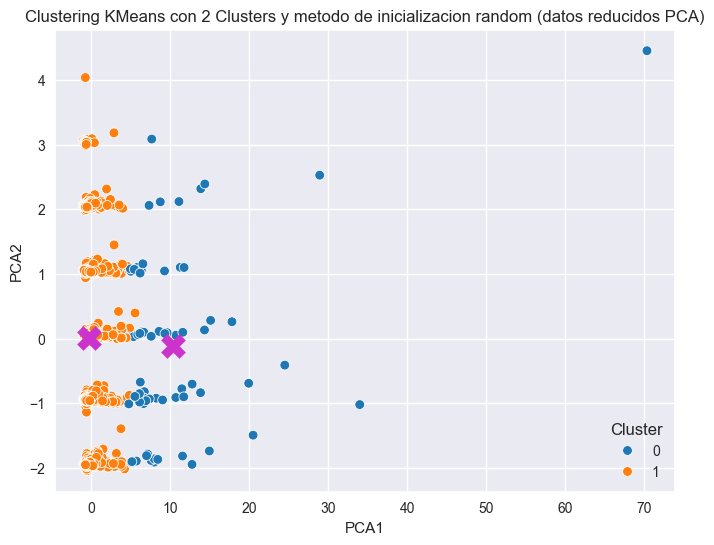

In [72]:
# Realizar clustering KMeans con el numero de clusters y metodo de inicializacion elegidos
kmeans = KMeans(n_clusters = best_k, init = best_init, n_init = 10, max_iter = 500, random_state = 42)
kmeans_labels = kmeans.fit_predict(customer_data_scaled)

# Obtenermos la frecuencia de clusters con los mejores parametros (basado en silhouette score)
cluster_frecuency = Counter(kmeans_labels)

# Mostrar la frecuencia de cluster
print(cluster_frecuency)

# Graficar PCA
pca = PCA(n_components = optimal_k)
pca_transformed = pca.fit_transform(customer_data_scaled)

df_pca = pd.DataFrame(pca_transformed, index = customer_data.index, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])
df_pca['Cluster'] = kmeans_labels

centroids = kmeans.cluster_centers_
controids_pca = pca.transform(centroids)

plt.figure(figsize = (8, 6))
sns.scatterplot(
  x = 'PCA1',
  y = 'PCA2',
  hue = 'Cluster',
  palette = 'tab10',
  data = df_pca
)
plt.scatter(
  controids_pca[:, 0],
  controids_pca[:, 1],
  s = 300,
  c = '#CC33CC',
  marker = 'X',
  label = 'Centroides'
)
plt.title(f'Clustering KMeans con {best_k} Clusters y metodo de inicializacion {best_init} (datos reducidos PCA)')

# Mostrar Grafico
plt.show()

# 13 | SpectralClustering 📕

In [73]:
# Crear una variable para guardar los resultados
result = []

# Iterar a traves de diferentes numeros de clusters para evaluar metricas
for k in range(2, 11):
  spectral = SpectralClustering(n_clusters = k, affinity = 'nearest_neighbors', random_state = 42, n_init = 10)
  spectral_labels = spectral.fit_predict(customer_data_scaled)
  
  silhouette = silhouette_score(customer_data_scaled, spectral_labels)
  db_score = davies_bouldin_score(customer_data_scaled, spectral_labels)
  ch_score = calinski_harabasz_score(customer_data_scaled, spectral_labels)
  
  # Guardamos el resultado
  result.append((k, silhouette, db_score, ch_score))

# Convertir los resultados a un DataFramr
results_df = pd.DataFrame(result, columns = ['Numero de Clusters', 'Silhouette Score', 'Davies Boulding Score', 'Calinski Harabasz Score'])

# Mostrar los resultados
print(Fore.RED + """
********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering:
********************************************************************************************************************
""")
display(results_df.sort_values(by = ['Silhouette Score'], ascending = False))

# Determinar el mejor numero de clusters basandonos en el Silhouette Score
best_k = results_df.loc[results_df['Silhouette Score'].idxmax(), 'Numero de Clusters']

# Imprimir resultado
print(f'Mejor Numero de Clusters (basado en el Silhouette Score): {best_k}')


********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering:
********************************************************************************************************************



,Numero de Clusters,Silhouette Score,Davies Boulding Score,Calinski Harabasz Score
0,2,0.209462,1.536138,446.908432
1,3,0.145900,2.100088,292.609613
4,6,0.056998,2.648399,310.333338
7,9,0.056740,2.005906,242.254817
6,8,0.054239,1.982480,274.008738
8,10,0.052160,1.962515,223.813377
5,7,0.043679,2.212769,284.320588
3,5,0.031520,2.322218,226.633435
2,4,0.007513,2.326578,196.937563


Mejor Numero de Clusters (basado en el Silhouette Score): 2


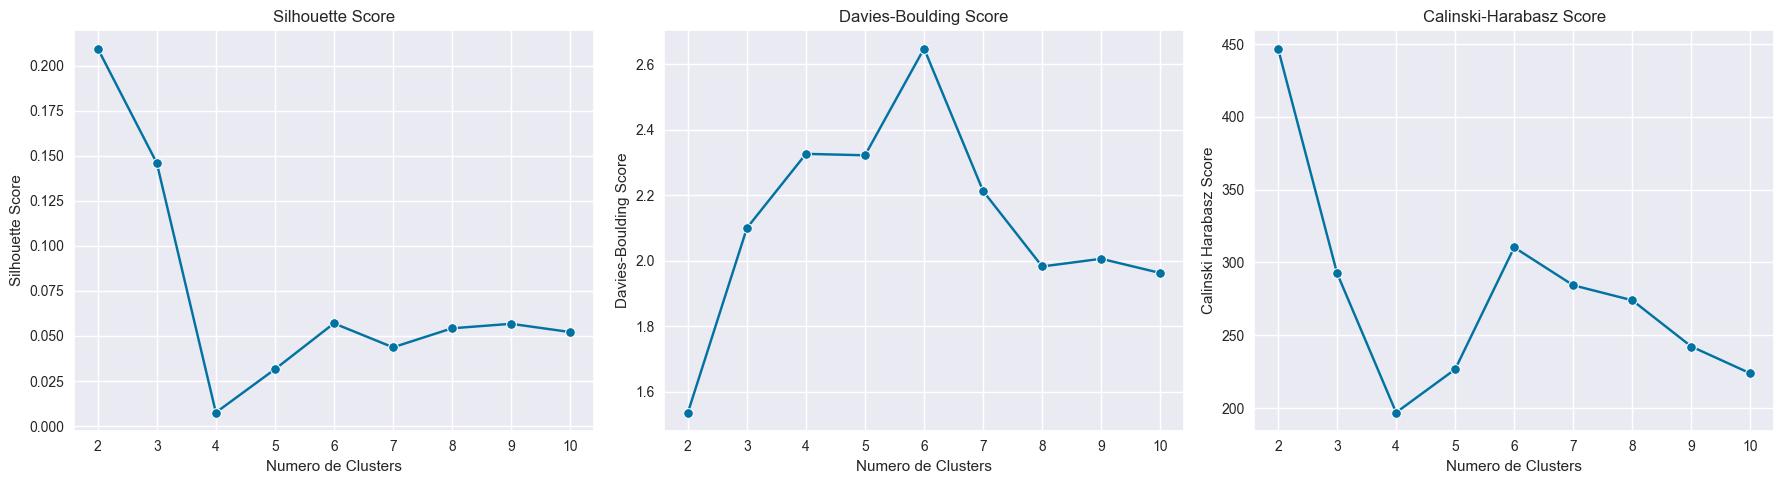

In [74]:
# Definir una funcion para graficar las metricas de evaluacion
def plot_evaluation_metrics(results_df):
  fig, axs = plt.subplots(1, 3, figsize = (18, 5))
  
  # Graficar Silhouette Score
  sns.lineplot(
    data = results_df,
    x = 'Numero de Clusters',
    y = 'Silhouette Score',
    ax = axs[0],
    marker = 'o'
  )
  axs[0].set_title('Silhouette Score')
  axs[0].set_xlabel('Numero de Clusters')
  axs[0].set_ylabel('Silhouette Score')
  
  # Graficar Davies Bouldin Score
  sns.lineplot(
    data = results_df,
    x = 'Numero de Clusters',
    y = 'Davies Boulding Score',
    ax = axs[1],
    marker = 'o'
  )
  axs[1].set_title('Davies-Boulding Score')
  axs[1].set_xlabel('Numero de Clusters')
  axs[1].set_ylabel('Davies-Boulding Score')
  
  # Graficar Calinski Harabasz Score
  sns.lineplot(
    data = results_df,
    x = 'Numero de Clusters',
    y = 'Calinski Harabasz Score',
    ax = axs[2],
    marker = 'o'
  )
  axs[2].set_title('Calinski-Harabasz Score')
  axs[2].set_xlabel('Numero de Clusters')
  axs[2].set_ylabel('Calinski Harabasz Score')
  
  # Ajustrar el grafico para evitar que los elementos esten sobreouestos
  plt.tight_layout()
  
  # Mostrar el grafico
  plt.show()

# Graficas las metricas de evaluacion
plot_evaluation_metrics(results_df)

Counter({0: 2189, 1: 1160})


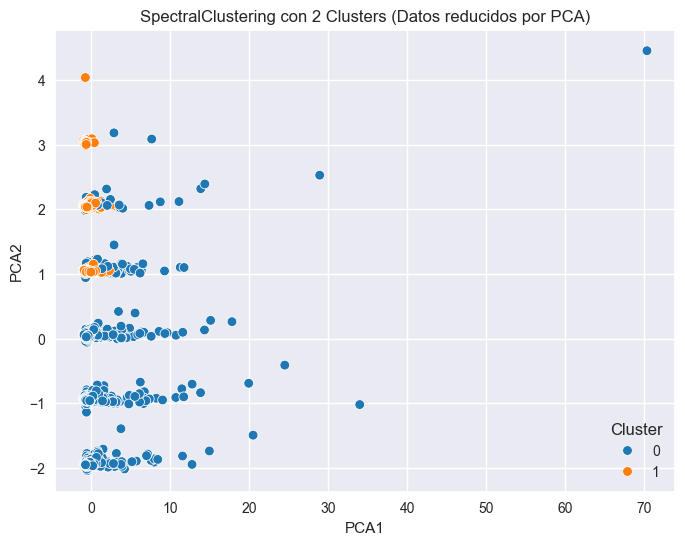

In [75]:
# Realizar SpectralClustering con el numero de clusters elegido
spectral = SpectralClustering(n_clusters = best_k, affinity = 'nearest_neighbors', n_init = 10, random_state = 42)

# Obtener las etiquetas
spectral_labels = spectral.fit_predict(customer_data_scaled)

# Obtener la frecuencia de clusters
cluster_frecuency = Counter(spectral_labels)

# Imprimir la frecuencia
print(cluster_frecuency)

# Graficar PCA
pca = PCA(n_components = optimal_k)
pca_transformed = pca.fit_transform(customer_data_scaled)

# Convertir a DataFrame
df_pca = pd.DataFrame(pca_transformed, index = customer_data.index, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])

# Crear una columna nueva y asignarle los clusters
df_pca['Cluster'] = spectral_labels

# Crear Figura
plt.figure(figsize = (8, 6))
sns.scatterplot(
  data = df_pca,
  x = 'PCA1',
  y = 'PCA2',
  hue = 'Cluster',
  palette = 'tab10'
)
plt.title(f'SpectralClustering con {best_k} Clusters (Datos reducidos por PCA)')
plt.show()

# 14 | AgglomerativeClustering 📗

In [76]:
# Crear varible para guardar los resultados
result = []

# Iterar a traves de diferentes numeros de clusters para evaluar las metricas
for k in range(2, 11):
  agglomerative_clustering = AgglomerativeClustering(n_clusters = k)
  agglomerative_labels = agglomerative_clustering.fit_predict(customer_data_scaled)
  
  # Obtener las metricas
  silhouette = silhouette_score(customer_data_scaled, agglomerative_labels)
  db_score = davies_bouldin_score(customer_data_scaled, agglomerative_labels)
  ch_score = calinski_harabasz_score(customer_data_scaled, agglomerative_labels)
  
  # Guardamos los resultados
  result.append((k, silhouette, db_score, ch_score))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(result, columns = ['Numero de Clusters', 'Silhouette Score', 'Davies Boulding Score', 'Calinski Harabasz Score'])

# Mostrar los resultados
print(Fore.RED + """
***********************************************************************************************************
                             Métricas de Evaluación de AgglomerativeClustering:
***********************************************************************************************************
""")
display(results_df.sort_values(by = ['Silhouette Score'], ascending = False))

# Determinar el mejor numero de clusters basado en el puntuaje de silhouette
best_k = results_df.loc[results_df['Silhouette Score'].idxmax(), 'Numero de Clusters']

# Imprimir el resultado
print(f'Mejor Numero de Clusters (basado en Silhouette Score) : {best_k}')


***********************************************************************************************************
                             Métricas de Evaluación de AgglomerativeClustering:
***********************************************************************************************************



,Numero de Clusters,Silhouette Score,Davies Boulding Score,Calinski Harabasz Score
0,2,0.644579,0.918516,804.109646
1,3,0.626104,0.602592,800.444683
5,7,0.286415,0.969683,717.457699
4,6,0.281663,0.938484,735.949159
3,5,0.274161,1.030509,765.545965
2,4,0.268701,1.054016,820.056389
8,10,0.241832,1.178727,680.549922
7,9,0.240958,1.298126,685.301685
6,8,0.224028,1.005561,702.402896


Mejor Numero de Clusters (basado en Silhouette Score) : 2


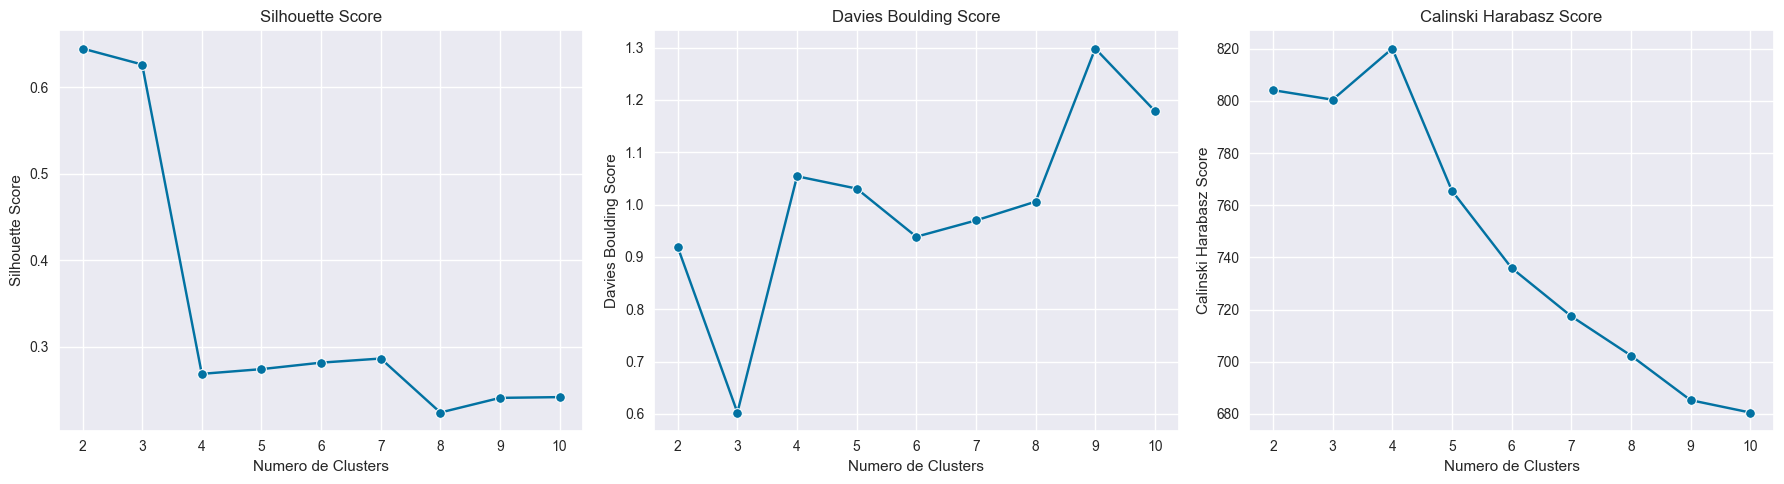

In [77]:
# Graficar las metricas de evaluacion
fig, axs = plt.subplots(1, 3, figsize = (18, 5))

# Graficar Silhouette Score
sns.lineplot(
  data = results_df,
  x = 'Numero de Clusters',
  y = 'Silhouette Score',
  ax = axs[0],
  marker = 'o'
)
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Numero de Clusters')
axs[0].set_ylabel('Silhouette Score')

sns.lineplot(
  data = results_df,
  x = 'Numero de Clusters',
  y = 'Davies Boulding Score',
  ax = axs[1],
  marker = 'o'
)
axs[1].set_title('Davies Boulding Score')
axs[1].set_xlabel('Numero de Clusters')
axs[1].set_ylabel('Davies Boulding Score')

sns.lineplot(
  data = results_df,
  x = 'Numero de Clusters',
  y = 'Calinski Harabasz Score',
  ax = axs[2],
  marker = 'o'
)
axs[2].set_title('Calinski Harabasz Score')
axs[2].set_xlabel('Numero de Clusters')
axs[2].set_ylabel('Calinski Harabasz Score')

plt.tight_layout()

plt.show()

Counter({1: 3224, 0: 125})


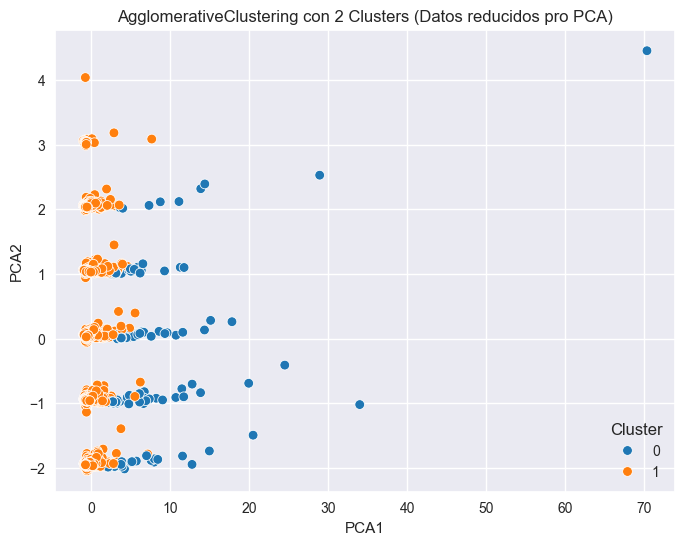

In [78]:
# Realizar AgglomerativeClustering con el mejor numero de clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters = best_k)

# Obtener las etiquetas del cluster
agglomerative_labels = agglomerative_clustering.fit_predict(customer_data_scaled)

# Obtener la frecuencia de clusteres
cluster_frecuency = Counter(agglomerative_labels)

# Imprimir la frecuencia
print(cluster_frecuency)

# Visualizar los resultados de AgglomerativeClustering con PCA
pca = PCA(n_components = optimal_k)
pca_transformed = pca.fit_transform(customer_data_scaled)

df_pca = pd.DataFrame(pca_transformed, index = customer_data.index, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])
df_pca['Cluster'] = agglomerative_labels

# Crear grafica
plt.figure(figsize = (8, 6))
sns.scatterplot(
  data = df_pca,
  x = 'PCA1',
  y = 'PCA2',
  hue = 'Cluster',
  palette = 'tab10',
)
plt.title(f'AgglomerativeClustering con {best_k} Clusters (Datos reducidos pro PCA)')
plt.show()

# 15 | DBSCAN 📒

In [79]:
result = []
best_silhouette = -1
best_eps = None
best_min_samples = None
best_dbscan_labels = None

# Iterar a traves de diferentes valores de eps y min_samples para evaluar las metricas
for eps in np.arange(start = 0.1, stop = 3.0, step = 0.2):
  for min_samples in range(1, 10, 1):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan_labels = dbscan.fit_predict(customer_data_scaled)
    
    # Filtrar los puntos considerados como ruido (label == -1)
    filtered_features = customer_data_scaled[dbscan_labels != -1]
    filtered_labels = dbscan_labels[dbscan_labels != -1]
    
    # Evaluar las metricas solo si se encuentran clusters (mas de un cluster)
    if len(np.unique(filtered_labels)) > 1:
      silhouette = silhouette_score(filtered_features, filtered_labels)
      db_score = davies_bouldin_score(filtered_features, filtered_labels)
      ch_score = calinski_harabasz_score(filtered_features, filtered_labels)
      
      # Guardar los resultados
      result.append((eps, min_samples, silhouette, db_score, ch_score, len(np.unique(filtered_labels))))
      
      # Actualizar los mejores parametros basados en el puntuaje silhouette
      if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_eps = eps
        best_min_samples = min_samples
        best_dbscan_labels = dbscan_labels

# Convertir los resultados a un DataFrame para facilitar analisis
results_df = pd.DataFrame(result, columns = ['eps', 'min_samples', 'Silhouette Score', 'Davies Boulding Score', 'Calinski Harabasz Score', 'Numero de Clusters'])

# Mostrar los resultados
print(Fore.RED + """
********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering:
********************************************************************************************************************
""")
display(results_df.sort_values(by = ['Silhouette Score'], ascending = False))

# Mostrar los mejores valores encontrados
print(f'Mejor valor de eps: {best_eps}')
print(f'Mejor valor de min_samples: {best_min_samples}')
print(f'Mejor Silhouette Score: {best_silhouette}')


********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering:
********************************************************************************************************************



,eps,min_samples,Silhouette Score,Davies Boulding Score,Calinski Harabasz Score,Numero de Clusters
8,0.1,9,0.779506,0.271189,4517.737768,10
66,1.7,4,0.756535,0.263668,104.222635,2
72,1.9,4,0.753591,0.265674,100.966246,2
77,2.1,5,0.743721,0.291954,115.492177,2
88,2.5,6,0.735750,0.324261,125.382163,2
...,...,...,...,...,...,...
11,0.3,3,-0.171718,1.120293,103.814381,38
45,1.1,1,-0.198062,0.372143,25.336519,256
18,0.5,1,-0.233129,0.424945,37.003786,760
10,0.3,2,-0.301048,0.846207,46.399651,104


Mejor valor de eps: 0.1
Mejor valor de min_samples: 9
Mejor Silhouette Score: 0.7795062390217108


Counter({-1: 3196, 0: 30, 3: 24, 9: 17, 1: 17, 2: 13, 5: 12, 7: 11, 4: 10, 8: 10, 6: 9})


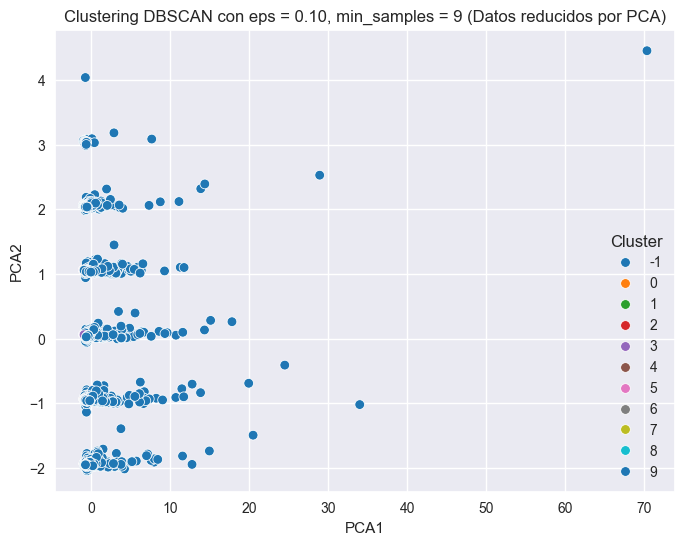

In [80]:
# Obtener la frecuencia de Clusters
cluster_frecuency = Counter(best_dbscan_labels)

# Imprimir la frecuencia
print(cluster_frecuency)

# Visualizar los mejores resultados del mejor modelo DBSCAN utilizando PCA para reduccion de dimensionalidad
pca = PCA(n_components = optimal_k)
pca_transformed = pca.fit_transform(customer_data_scaled)

df_pca = pd.DataFrame(pca_transformed, index = customer_data.index, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])
df_pca['Cluster'] = best_dbscan_labels

# Graficar los clusters resultante
plt.figure(figsize = (8, 6))
sns.scatterplot(
  data = df_pca,
  x = 'PCA1',
  y = 'PCA2',
  hue = 'Cluster',
  palette = 'tab10',
)
plt.title(f'Clustering DBSCAN con eps = {best_eps:.2f}, min_samples = {best_min_samples} (Datos reducidos por PCA)')

# Mostrar el grafico
plt.show()

# 16 | HDBSCAN 📙

In [82]:
result = []

# Iterar a traves de diferentes valores de min_cluster_size y min_samples para evaluar las metricas
for min_cluster_size in range(2, 11):
  for min_samples in range(2, 11):
    hdbscan_clustering = HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples)
    hdbscan_labels = hdbscan_clustering.fit_predict(customer_data_scaled)

    # Filtrar los puntos de ruido para los calculos de las metricas
    valid_points = hdbscan_labels != -1
  
    # Si hay puntos validos, calcular las metricas
    if valid_points.sum() > 0:
      silhouette = silhouette_score(customer_data_scaled[valid_points], hdbscan_labels[valid_points])
      db_score = davies_bouldin_score(customer_data_scaled[valid_points], hdbscan_labels[valid_points])
      ch_score = calinski_harabasz_score(customer_data_scaled[valid_points], hdbscan_labels[valid_points])
    else :
      silhouette = -1
      db_score = -1
      ch_score = -1
    
    # Agreagr los resultaods a la lista
    result.append((min_cluster_size, min_samples, silhouette, db_score, ch_score, len(np.unique(hdbscan_labels[valid_points]))))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(result, columns = ['Min Size del Cluster', 'Muestras minimas', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score', 'Numero de Clusters'])

# Mostrar los resultados
print(Fore.RED + """
********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering:
********************************************************************************************************************
""")
display(results_df.sort_values(by = ['Silhouette Score'], ascending = False))

# Determinar los mejores parametros basados en el Silhouette Score
best_params = results_df.loc[results_df['Silhouette Score'].idxmax()]
best_min_cluster_size = best_params['Min Size del Cluster']
best_min_samples = best_params['Muestras minimas']

# Imprimir los resultados
print(f'Mejor Tama;o Minimo del Cluster (basado en el Silhouette Score) : {best_min_cluster_size}')
print(f'Mejor Valor de Muestras Minimas (basados en el Silhouette Score) {best_min_samples}')


********************************************************************************************************************
                                      Metricas de Evaluacion de Clustering:
********************************************************************************************************************



,Min Size del Cluster,Muestras minimas,Silhouette Score,Davies Bouldin Score,Calinski Harabasz Score,Numero de Clusters
1,2,3,0.409161,0.672433,189.128499,328
0,2,2,0.372898,0.695161,147.103345,783
9,3,2,0.369472,0.763120,190.918953,370
10,3,3,0.362144,0.683144,226.076497,224
18,4,2,0.342065,0.773226,290.654466,209
...,...,...,...,...,...,...
3,2,5,0.038958,1.092615,116.368280,39
36,6,2,0.038358,0.934978,151.129898,49
28,5,3,0.019683,0.937275,150.038848,42
45,7,2,0.000408,1.150761,232.039962,24


Mejor Tama;o Minimo del Cluster (basado en el Silhouette Score) : 2.0
Mejor Valor de Muestras Minimas (basados en el Silhouette Score) 3.0


Counter({-1: 1953, 26: 45, 327: 26, 216: 21, 170: 18, 320: 18, 168: 16, 28: 12, 213: 12, 323: 12, 129: 11, 257: 11, 214: 11, 321: 11, 265: 11, 276: 11, 196: 10, 256: 10, 219: 10, 205: 9, 79: 9, 305: 9, 314: 9, 318: 9, 0: 8, 17: 8, 93: 8, 255: 8, 169: 8, 147: 8, 221: 8, 195: 8, 125: 8, 50: 7, 220: 7, 291: 7, 260: 7, 249: 7, 153: 7, 297: 7, 324: 7, 266: 7, 138: 6, 38: 6, 107: 6, 300: 6, 18: 6, 302: 6, 289: 6, 229: 6, 254: 6, 92: 6, 200: 6, 226: 6, 113: 6, 151: 6, 47: 6, 174: 5, 304: 5, 51: 5, 269: 5, 152: 5, 41: 5, 100: 5, 277: 5, 217: 5, 81: 5, 275: 5, 98: 5, 181: 5, 239: 5, 126: 5, 187: 5, 243: 5, 86: 5, 284: 5, 306: 5, 179: 5, 159: 5, 246: 5, 180: 5, 268: 5, 252: 5, 164: 5, 310: 5, 56: 5, 281: 5, 299: 5, 253: 5, 250: 5, 271: 5, 280: 5, 172: 4, 78: 4, 215: 4, 88: 4, 13: 4, 142: 4, 59: 4, 123: 4, 109: 4, 87: 4, 228: 4, 103: 4, 209: 4, 35: 4, 80: 4, 104: 4, 188: 4, 58: 4, 150: 4, 223: 4, 97: 4, 312: 4, 212: 4, 89: 4, 69: 4, 251: 4, 270: 4, 184: 4, 94: 4, 111: 4, 10: 4, 24: 4, 14: 4, 76: 

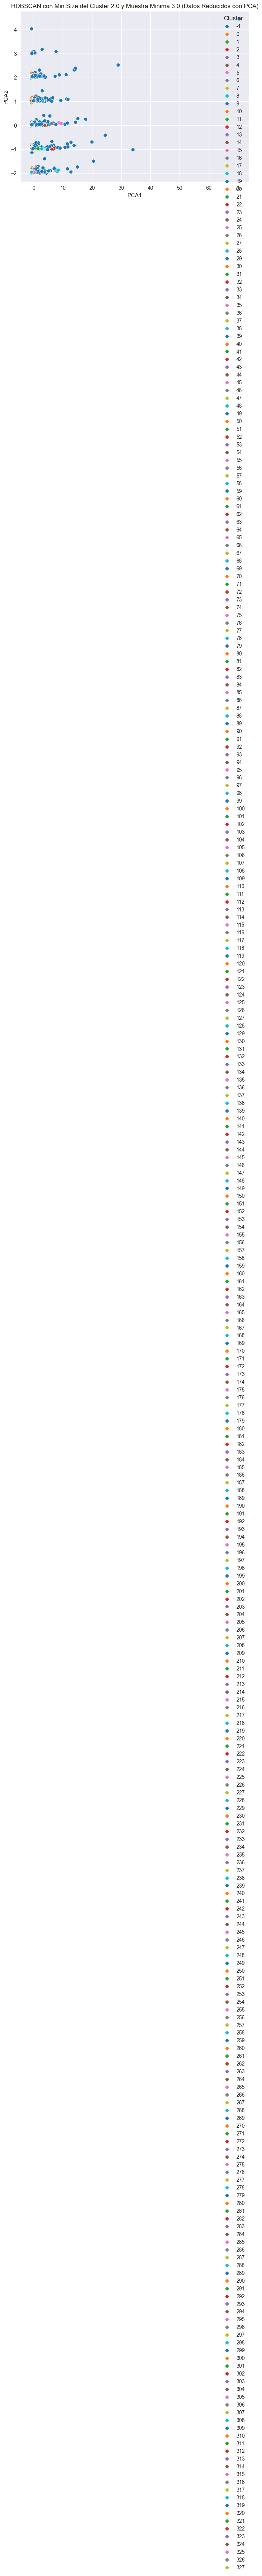

In [83]:
# Realizar clustering HDBSCAN con los mejores parametros
hdbscan_clustering = HDBSCAN(min_cluster_size = int(best_min_cluster_size), min_samples = int(best_min_samples))

# Obtener las etiquetas
hdbscan_labels = hdbscan_clustering.fit_predict(customer_data_scaled)

# Obtener la frecuencia de Clusters
cluster_frecuency = Counter(hdbscan_labels)

# Imprimir la frecuencia
print(cluster_frecuency)

# Visulizar los resultados de HDBSCAN con PCA
pca = PCA(n_components = optimal_k)
pca_transformed = pca.fit_transform(customer_data_scaled)

# Transformar el pca a un DataFrame
df_pca = pd.DataFrame(pca_transformed, index = customer_data.index, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])

# Crear columna con los clusters al pca
df_pca['Cluster'] = hdbscan_labels

# Crear una grafica
plt.figure(figsize = (8, 6))
sns.scatterplot(
  data = df_pca,
  x = 'PCA1',
  y = 'PCA2',
  hue = 'Cluster',
  palette = 'tab10'
)
plt.title(f'HDBSCAN con Min Size del Cluster {best_min_cluster_size} y Muestra Minima {best_min_samples} (Datos Reducidos con PCA)')

# Mostrar el grafico
plt.show()